<a href="https://colab.research.google.com/github/sayyed-uoft/CRA/blob/main/25_Nov_2021_Vector_Institute_Text_Classification_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vector Institute - CRA AI Fundamentals and Ethical Considerations Workshop

### Thank you for joining Day 2 of the Vector Institute, 'AI Fundamentals and Ethical Considerations' workshop series.

If you have any questions or if you would like to learn more about this program, contact: learn@vectorinstitute.ai

#Day 2: Text Classification


In this notebook, we will use a pre-trained deep learning model to process some text. We will then use the output of that model to classify the text. The text is a list of narratives from consumer complaints and we will classify each narrative to one of the complaint classes.

## Models: Consumer Complaint Classification
Our goal is to create a model that takes the text of a complaint and produces the class code. 

Under the hood, the model is actually made up of two models.

* DistilBERT processes the text and passes along some information it extracts from the text on to the next model. DistilBERT is a smaller version of BERT developed and open sourced by the team at HuggingFace. It’s a lighter and faster version of BERT that roughly matches its performance.
* The next model, a basic Logistic Regression model from scikit learn will take in the result of DistilBERT’s processing, and classify the text. We will train both binary and multi-class classifiers and will explain the methods to evaluate the results..

The data we pass between the two models is a vector of size 768. We can think of this of vector as an embedding for the sentence that we can use for classification.

## Problem
Each week the Consumer Financial Protection Bureau sends thousands of consumer complaints about financial products and services to the company for a response. Classify those consumer complaints into the product category it belongs to using the description of the complaint.

## Dataset
The dataset is a small subset of data extracted from Data.gov website. We extracted only a very small part due to the memory limitation of Google Colab.  The data is already clean. It is made of two columns:

1. **Product:** the complaint class
1. **Consumer complaint narrative:** the text of the complaint

## Installing the transformers library
Let's start by installing the huggingface transformers library so we can load our deep learning NLP model. Also, importing the required Python packages.

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 61.7 MB/s 
     |████████████████████████████████| 895 kB 50.7 MB/s 
     |████████████████████████████████| 3.3 MB 33.8 MB/s 
     |████████████████████████████████| 59 kB 6.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import torch
import transformers as ppb
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

## Importing the dataset
We'll use pandas to read the dataset and load it into a dataframe.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/sayyed-uoft/CRA/main/customer_complaints_samples.csv')

Let's look at the data

In [ ]:
df

,Product,Consumer complaint narrative
0,"Credit reporting, credit repair services, or o...",XXXX is currently reporting incorrect informat...
1,"Credit reporting, credit repair services, or o...",I Have Filed A Dispute In Regards To The Incor...
2,"Credit reporting, credit repair services, or o...",I am requesting a method of verification of th...
3,"Credit reporting, credit repair services, or o...",A Car dealer scammed a car in my name that I h...
4,"Credit reporting, credit repair services, or o...","At this time, I respectfully request a copy of..."
...,...,...
1332,"Payday loan, title loan, or personal loan",On XX/XX/2021 I called to try and get in conta...
1333,Debt collection,Applying for a refinance and the title company...
1334,"Credit reporting, credit repair services, or o...",I called XXXX to remove two inquiries off of m...
1335,Credit card or prepaid card,On XX/XX/XXXX my bill did not go through accou...


Let's look at the distribution of the products (labels):

In [ ]:
df['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    934
Debt collection                                                                 196
Credit card or prepaid card                                                      75
Mortgage                                                                         55
Checking or savings account                                                      40
Vehicle loan or lease                                                            18
Payday loan, title loan, or personal loan                                         9
Student loan                                                                      5
Money transfer, virtual currency, or money service                                5
Name: Product, dtype: int64

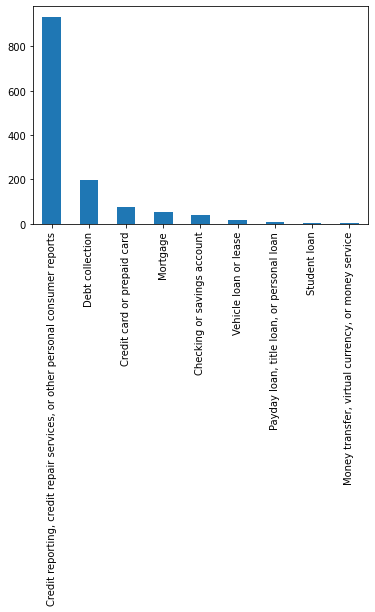

In [ ]:
df['Product'].value_counts().plot.bar()
plt.show()

## Loading the Pre-trained BERT model
Let's now load a pre-trained BERT model. 

In [ ]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Right now, the variable `model` holds a pretrained distilBERT model -- a version of BERT that is smaller, but much faster and requiring a lot less memory.

## Preparing the Dataset
Before we can hand our narratives to BERT, we need to do some minimal processing to put them in the format it requires.

### Tokenization
Our first step is to tokenize the narratives -- break them up into word and subwords in the format BERT is comfortable with. The model accepts only 512 tockens. So, we truncate longer messages.

In [ ]:
# Tokenize the narratives
tokenized = df['Consumer complaint narrative'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True)))

In [ ]:
# view a few tockenized samples
tokenized.head()

0    [101, 22038, 20348, 2003, 2747, 7316, 16542, 2...
1    [101, 1045, 2031, 6406, 1037, 7593, 1999, 1236...
2    [101, 1045, 2572, 17942, 1037, 4118, 1997, 226...
3    [101, 1037, 2482, 11033, 8040, 27479, 1037, 24...
4    [101, 2012, 2023, 2051, 1010, 1045, 26438, 213...
Name: Consumer complaint narrative, dtype: object


### Padding
After tokenization, `tokenized` is a list of narratives -- each narrative is represented as a list of tokens. We want BERT to process our examples all at once (as one batch). It's just faster that way. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths).

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

Our dataset is now in the `padded` variable, we can view its dimensions below:

In [ ]:
np.array(padded).shape

(1337, 222)

### Masking
If we directly send `padded` to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. That's 'attention_mask':

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(1337, 222)

## Narrative Embeddings
Now that we have our model and inputs ready, let's run our model!

The `model()` function runs our narratives through BERT. The results of the processing will be returned into `last_hidden_states`.

In [ ]:
# Note: This will take a while
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. The way BERT does sentence classification, is that it adds a token called `[CLS]` (for classification) at the beginning of every sentence. The output corresponding to that token can be thought of as an embedding for the entire sentence.

We'll save those in the `features` variable, as they'll serve as the features to our logitics regression model.

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()

## Classification

The last step is to use the narrative representations as the input of a simple linear classification model. For the output we will use the index of the associated categories.

We will train two models:
1. Binary classification (if the complaint’s type is ‘Credit reporting, credit repair services, or other personal consumer reports’)
1. Multi-class classification


## Binary Classification

The labels indicating which sentence is positive and negative now go into the `labels` variable

In [ ]:
labels = df['Product'] == 'Credit reporting, credit repair services, or other personal consumer reports'
labels

0        True
1        True
2        True
3        True
4        True
        ...  
1332    False
1333    False
1334     True
1335    False
1336     True
Name: Product, Length: 1337, dtype: bool

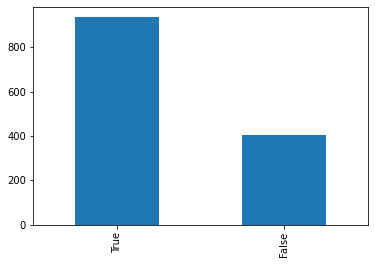

In [ ]:
labels.value_counts().plot.bar()
plt.show()

### Model Training and Validation
We now train and validate a LogisticRegression model. We will use "coss_val_scores" to perform a 5-fold cross validation and we choose "accuracy" as the score.

In [ ]:
lr_clf = LogisticRegression()
scores = cross_val_score(lr_clf, features, labels, scoring='accuracy', cv=5)
print("Score is {:.2f} +- {:.2f}".format(scores.mean(), 2*scores.std()))

Score is 0.84 +- 0.07


How good is this score? What can we compare it against? Let's first look at a dummy classifier. A dummy classifieris a classifier that makes predictions using simple rules. By dedfault, always predicts the class that maximizes the class prior.

In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, features, labels)
print("Score is {:.2f} +- {:.2f}".format(scores.mean(), 2*scores.std()))

Score is 0.70 +- 0.00


So our model clearly does better than a dummy classifier. But, the data is not balanced and accuracy is not a good score. We should use confusion matrix to analyze the results and use the combination of precision and recall scores.


In [ ]:
# Calculate and print confusion matrix
pred = cross_val_predict(lr_clf, features, labels, cv=5)
conf_mx = confusion_matrix(labels, pred)
conf_mx

array([[268, 135],
       [ 78, 856]])

In [ ]:
# Calculate recall scores
scores = cross_val_score(lr_clf, features, labels, scoring='recall', cv=5)
print("Score is {:.2f} +- {:.2f}".format(scores.mean(), 2*scores.std()))

Score is 0.92 +- 0.03


In [ ]:
# Calculate precision scores
scores = cross_val_score(lr_clf, features, labels, scoring='precision', cv=5)
print("Score is {:.2f} +- {:.2f}".format(scores.mean(), 2*scores.std()))

Score is 0.86 +- 0.07


## Multi-class Classification

In [ ]:
# convert classes to class numbers
factorized = df['Product'].factorize()
labels_multi = factorized[0]
labels_text = factorized[1]

In [ ]:
# Calculate accuracy scores
scores = cross_val_score(lr_clf, features, labels_multi, scoring='accuracy', cv=5)
print("Score is {:.2f} +- {:.2f}".format(scores.mean(), 2*scores.std()))

Score is 0.77 +- 0.05


In [ ]:
# Calculate accuracy scores (Dummy Classifier)
scores = cross_val_score(clf, features, labels_multi)
scores

array([0.69776119, 0.69776119, 0.70037453, 0.70037453, 0.69662921])

In [ ]:
# Claculate and print confusion matrix
pred = cross_val_predict(lr_clf, features, labels_multi, cv=5)

In [ ]:
conf_mx = confusion_matrix(labels_multi, pred)
conf_mx

array([[874,  41,   0,   7,  11,   0,   0,   0,   1],
       [ 97,  90,   0,   3,   5,   1,   0,   0,   0],
       [  4,   2,   0,   2,   1,   0,   0,   0,   0],
       [ 17,   7,   1,  26,   4,   0,   0,   0,   0],
       [ 27,  13,   0,   2,  28,   5,   0,   0,   0],
       [ 17,   5,   1,   2,   6,   9,   0,   0,   0],
       [  0,   2,   0,   0,   2,   1,   0,   0,   0],
       [  7,   5,   0,   2,   2,   0,   0,   2,   0],
       [  4,   0,   0,   1,   0,   0,   0,   0,   0]])

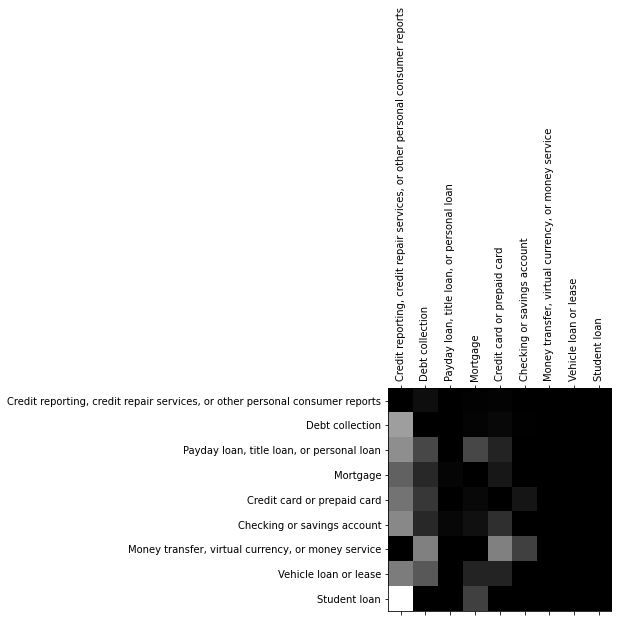

In [ ]:
# Plot the multi-clkass confusion matrix.
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.xticks(range(9), labels_text, rotation=90)
plt.yticks(range(9), labels_text)
plt.show()

Try to interpret the confusion matrix.

# Contact Information

Congratulations, you have completed the tutorial for Day 2 of the Vector Institute 'AI Fundamentals and Ethical Considerations' program! Thank you for your time and attention.


*   Instructor: Sayyed Nezhadi 
*   Program Director: Shingai Manjengwa 
*   Contact: learn@vectorinstitute.ai

Never stop learning!